# CS 228 HW4, Shaheriar Malik

In [152]:
import time
import random
import torch
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torchvision.transforms.transforms import ToTensor
import torch.optim as optim
from IPython.display import clear_output

In [153]:
# load data
train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

# convert to numpy array from tensor
X_train = train.data.numpy()
y_train = train.targets.numpy()
X_test = test.data.numpy().astype(np.float32)
y_test = test.targets.numpy()

# convert to 1D array
X_flat_train = X_train.reshape(60000, 784)
X_flat_test = X_test.reshape(10000, 784)

# sample 1000 images from each class at random
X_sample = np.zeros((10000, 784), dtype=np.uint8)
y_sample = np.zeros((10000), dtype=np.uint8)
for i in range(10):
    idx = np.where(y_train == i)[0]
    idx_sample = np.random.choice(idx, 1000, replace=False)
    X_sample[i*1000:(i+1)*1000] = X_flat_train[idx_sample]
    y_sample[i*1000:(i+1)*1000] = y_train[idx_sample]
c = list(zip(X_sample, y_sample))
random.shuffle(c)
X_sample, y_sample = zip(*c)
X_sample = np.array(X_sample).astype(np.float32)
y_sample = np.array(y_sample)

# z score normalization
X_sample = (X_sample - np.mean(X_sample)) / np.std(X_sample)
X_flat_test = (X_flat_test - np.mean(X_flat_test)) / np.std(X_flat_test)

# one hot encoding
y_oh_train = np.zeros((10000, 10))
y_oh_test = np.zeros((10000, 10))
y_oh_train[np.arange(10000), y_sample] = 1    
y_oh_test[np.arange(10000), y_test] = 1

In [154]:
print(X_sample.shape)
print(X_flat_test.shape)
print(y_sample.shape)
print(y_test.shape)

(10000, 784)
(10000, 784)
(10000,)
(10000,)


In [155]:
def plot(k, p, train_accuracy, test_accuracy):
    plt.figure(figsize=(8, 6), dpi=80)
    plt.subplot(1, 2, 1)
    plt.xticks(k)
    plt.yticks(np.arange(0,1,0.1))
    plt.ylim(0, 1)
    for i in range(3):
        plt.plot(k, train_accuracy[:, i], label='p = {}'.format(p[i]), marker='o', linestyle='-')
    plt.title('Train Accuracy')
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xticks(k)
    plt.yticks(np.arange(0,1,0.1))
    plt.ylim(0, 1)
    for i in range(3):
        plt.plot(k, test_accuracy[:, i], label='p = {}'.format(p[i]), marker='o', linestyle='-')
    plt.title('Test Accuracy')
    plt.xlabel('k')
    plt.legend()
    plt.show()

## Q1. Neural Net Classifier $f(x) = \text{softmax}(V\text{ReLU}(W x))$

In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class shallow_nn(torch.nn.Module):
    def __init__(self, k, p):
        super(shallow_nn, self).__init__()
        self.k = k
        self.p = p
        self.W = torch.nn.Linear(784, k)
        self.V = torch.nn.Linear(k, 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.dropout = torch.nn.Dropout(p=(1-p))
        torch.nn.init.kaiming_normal_(self.W.weight, nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.V.weight, nonlinearity='relu')
        
    def forward(self, x):
        return self.softmax(self.V(self.relu(self.dropout(self.W(x)))))

## Q2. Width grid $K = [1, 5, 10, 20, 40]$ and dropout grid $P = [0.1, 0.5, 1.0]$

In [157]:
list_k = [1,5, 10, 20, 40]
list_p = [0.1, 0.5, 1]
epochs = 80
batch_size = 1000
def training(K, P, X, y, xtest, ytest):
    train_loss = np.zeros((len(K), len(P)))
    test_loss = np.zeros((len(K), len(P)))
    train_accuracy = np.zeros((len(K), len(P)))
    test_accuracy = np.zeros((len(K), len(P)))
    print('k              p             train_loss     test_loss      train accuracy test accuracy')
    for k in range(len(K)):
        for p in range(len(P)):
            model = shallow_nn(K[k], P[p]).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.01)
            loss_function = torch.nn.CrossEntropyLoss()
            model.train()
            for epoch in range(epochs):
                for i in range(0, len(y), batch_size):
                    optimizer.zero_grad()
                    output = model(torch.from_numpy(X[i:i+batch_size]).to(device))
                    loss = loss_function(output, torch.from_numpy(y[i:i+batch_size]).to(device))
                    loss.backward()
                    optimizer.step()

            model.eval()
            output = model(torch.from_numpy(X).to(device))
            pred_train = np.argmax(output.cpu().detach().numpy(), axis=1)
            loss = loss_function(output, torch.from_numpy(y).to(device))
            train_loss[k, p] = loss.item()

            output = model(torch.from_numpy(xtest).to(device))
            pred_test = np.argmax(output.cpu().detach().numpy(), axis=1)
            loss = loss_function(output, torch.from_numpy(ytest).to(device))
            test_loss[k, p] = loss.item()
            
            train_accuracy[k, p] = np.sum(pred_train == y) / 10000
            test_accuracy[k, p] = np.sum(pred_test == ytest) / 10000
            print('{:<12}   {:<12}  {:<12.2f}   {:<12.2f}   {:<12.2f}   {:<12.2f}'.format(K[k], P[p], train_loss[k, p], test_loss[k, p], train_accuracy[k, p], test_accuracy[k, p]))
    return train_loss, test_loss, train_accuracy, test_accuracy
            

### Fixing p = 1.0

k              p             train_loss     test_loss      train accuracy test accuracy
1              1             2.12           2.13           0.34           0.34        
5              1             1.70           1.74           0.77           0.73        
10             1             1.58           1.61           0.88           0.85        
20             1             1.50           1.54           0.96           0.92        
40             1             1.48           1.52           0.98           0.94        
Time (s) = 18.124903678894043


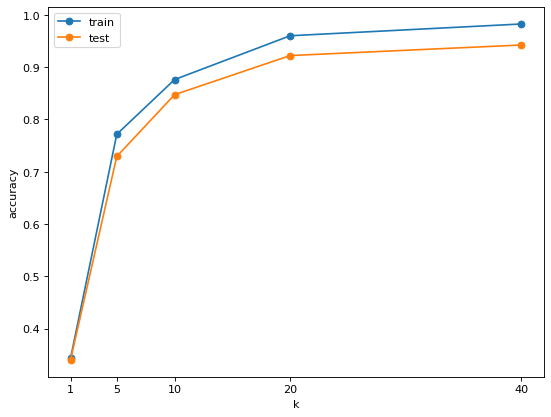

In [158]:
start = time.time()
train_loss, test_loss, train_accuracy, test_accuracy = training(list_k, [1], X_sample, y_sample, X_flat_test, y_test)
end = time.time()
print('Time (s) =', end - start)
plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(list_k)
plt.plot(list_k, train_accuracy[:, 0], label='train', marker='o', linestyle='-')
plt.plot(list_k, test_accuracy[:, 0], label='test', marker='o', linestyle='-')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#### Comments
We can see that as k increases, the accuracy does in fact improve. The accuracy becomes near 100% when k = 40.

### Train and Test accuracy as a function of k

k              p             train_loss     test_loss      train accuracy test accuracy
1              0.1           2.30           2.30           0.10           0.10        
1              0.5           2.19           2.20           0.25           0.25        
1              1             2.15           2.16           0.28           0.27        
5              0.1           2.10           2.10           0.35           0.35        
5              0.5           1.77           1.79           0.72           0.70        
5              1             1.56           1.60           0.91           0.86        
10             0.1           1.95           1.96           0.51           0.50        
10             0.5           1.65           1.67           0.82           0.80        
10             1             1.68           1.71           0.78           0.75        
20             0.1           1.72           1.71           0.79           0.80        
20             0.5           1.54         

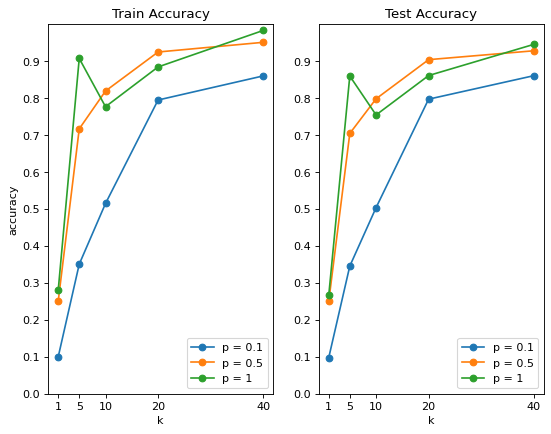

In [159]:
start = time.time()
train_loss, test_loss, train_accuracy, test_accuracy = training(list_k, list_p, X_sample, y_sample, X_flat_test, y_test)
end = time.time()
print('Time (s) =', end - start)
plot(list_k, list_p, train_accuracy, test_accuracy)

#### Training comments:
We can see that when p is smaller, it is more difficult to optimize since it introduces a factor of randomization into the training. For each of the p values, k = 40 is the value at which training accuracy becomes near 100%.

#### Testing comments:
In this scenario, we don't see a significant difference between test and train accuracy but in some of the cases listed above, the test accuracy is higher than train. The best test accuracy is achieved when k = 40 and p = 1

## Q3. Random values for y

### Train and test accuracy as a function of k

k              p             train_loss     test_loss      train accuracy test accuracy
1              0.1           2.30           2.30           0.10           0.10        
1              0.5           2.30           2.30           0.10           0.10        
1              1             2.30           2.30           0.10           0.10        
5              0.1           2.19           2.11           0.24           0.32        
5              0.5           2.03           1.85           0.43           0.62        
5              1             1.95           1.75           0.52           0.71        
10             0.1           2.18           2.08           0.28           0.39        
10             0.5           1.94           1.72           0.53           0.77        
10             1             1.84           1.58           0.62           0.88        
20             0.1           2.08           1.91           0.37           0.56        
20             0.5           1.86         

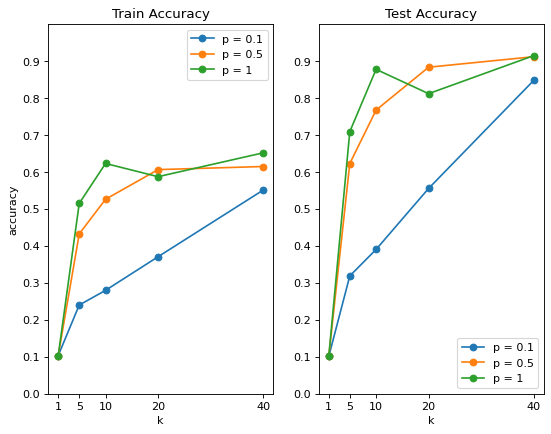

In [160]:
np.random.seed(0)
idx = np.random.choice(10000, 4000, replace=False)
y_noisy = y_sample.copy()
y_noisy[idx] = np.random.randint(0, 10, 4000)

y_oh_noisy = np.zeros((10000, 10))
y_oh_noisy[np.arange(10000), y_noisy] = 1

start = time.time()
train_loss, test_loss, train_accuracy, test_accuracy = training(list_k, list_p, X_sample, y_noisy, X_flat_test, y_test)
end = time.time()
print('Time (s) =', end - start)
plot(list_k, list_p, train_accuracy, test_accuracy)

## Comments

After adding noise, we can see a significant improvement for test accuracy over training accuracy. This is because noise combined with dropout forces the model to generalize better. Adding dropout for step 3 is more useful than step 2.